In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [62]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
date,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [63]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['date'])['y'].sum()
data = pd.DataFrame(data)
data

,y
date,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-11-27,16123000.0
2020-11-28,7344400.0
2020-11-29,31336000.0
...,...
2023-03-27,160134712.0
2023-03-28,895757.0
2023-03-29,58286000.0


In [64]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
date                   
2021-10-17  375372000.0
2021-10-24  287017000.0
2021-12-08  189834100.0
2022-01-12  262409500.0
2022-01-13  177271000.0
2022-01-16  184863000.0
2022-01-31  204342000.0
2022-02-16  182886300.0
2022-02-17  220170000.0
2022-02-28  213469000.0
2022-07-28  204959459.0
2022-09-17  192559703.0
2022-10-18  184679491.0
2022-11-03  250884985.0
2022-11-06  336473806.0
2022-11-20  326221966.0
2022-12-04  348875662.0
2022-12-07  305095300.0
2022-12-13  236500741.0
2022-12-18  354723498.0
2022-12-23  291265309.0
2023-01-02  281983243.0
2023-01-10  186120115.0
2023-01-16  266497112.0
2023-01-27  485893693.0
2023-01-30  313164440.0
2023-02-13  308880309.0
2023-02-27  222864584.0
2023-03-05  253894290.0
2023-03-07  326880253.0
2023-03-21  221348637.0
2023-03-23  225836091.0
Outliers ke- 2 :                        y
date                   
2021-10-19  151220000.0
2021-11-05  175035000.0
2021-11-11  155209000.0
2021-11-24  154454900.0
2022

,y
date,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-11-27,16123000.0
2020-11-28,7344400.0
2020-11-29,31336000.0
...,...
2023-03-26,6122998.0
2023-03-28,895757.0
2023-03-29,58286000.0


In [65]:
#INTERPOLASI

print(f"start date: {min(data.index)}, end date: {max(data.index)}")
data = data.asfreq('d')
data = data.interpolate(method='linear')
data = data.fillna(0)
data = data.astype({'y':'int'})
# data = data.astype({'y':'int'})
print(f'Number of rows with missing values: {data.isnull().mean()}')
data

start date: 2020-11-18 00:00:00, end date: 2023-04-09 00:00:00
Number of rows with missing values: y    0.0
dtype: float64


,y
date,
2020-11-18,21891600
2020-11-19,22673442
2020-11-20,23455285
2020-11-21,24237128
2020-11-22,25018971
...,...
2023-04-05,16273000
2023-04-06,12582250
2023-04-07,8891500


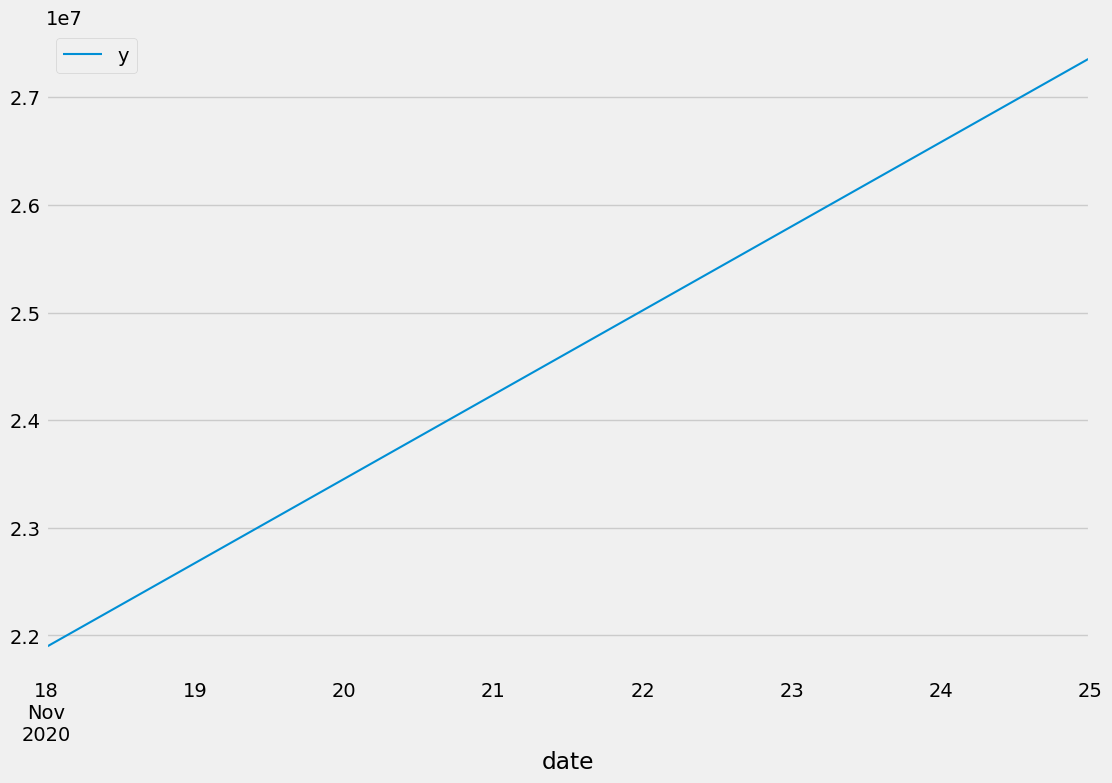

In [66]:
revenue_plot =data['y'].iloc[0:8].plot(
    figsize=(12,8),
    legend=True,
)

In [67]:
#Standar Scaler
#Standardize features by removing the mean and scaling to unit variance.

unscaled = data['y'].values.reshape(len(data['y']),1)
scaler = StandardScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
data['y'] = scaled
data['y']

date
2020-11-18   -0.428437
2020-11-19   -0.403998
2020-11-20   -0.379558
2020-11-21   -0.355119
2020-11-22   -0.330680
                ...   
2023-04-05   -0.604068
2023-04-06   -0.719436
2023-04-07   -0.834804
2023-04-08   -0.950173
2023-04-09   -1.065541
Freq: D, Name: y, Length: 873, dtype: float64

In [ ]:
# data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
# data['y']

Train dates : 2020-11-18 00:00:00 --- 2023-04-04 00:00:00  (n=868)
Test dates  : 2023-04-05 00:00:00 --- 2023-04-09 00:00:00  (n=5)


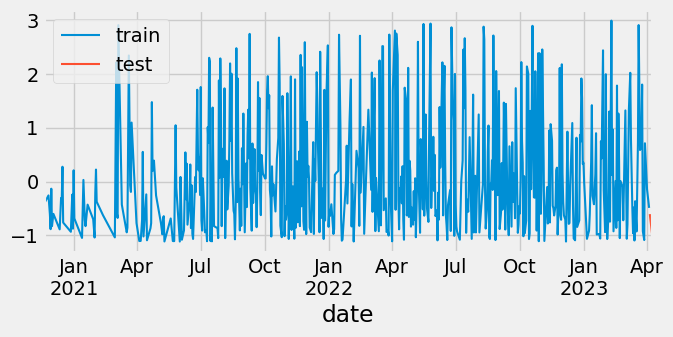

In [68]:
#PLOT DATA TRAIN & DATA TEST
steps = 5
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [69]:
#CARI BEST HPO PAKAI GRIDSEARCH + MASUKIN KE MODEL ARIMA

import warnings
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)

# Ignore the convergence warnings
warnings.filterwarnings("ignore")

# Grid search over all combinations of p, d, and q
best_rmse, best_order = float('inf'), None
for p, d, q in itertools.product(p_values, d_values, q_values):
        print(p,d,q)

        # Fit the ARIMA model to the training data
        model = ARIMA(data_train['y'].values,order=(p,q,d))
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
        predictions.index = data_test.index


        # Calculate the RMSE of the predictions
        rmse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )
        print(rmse)

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

0 0 0
0.7315615265813686
0 0 1
0.1464082472224711
0 0 2
1.479114197289397e-32
0 1 0
0.7053484978111999
0 1 1
0.9097686631085911
0 1 2
0.14619744732986367
0 2 0
0.6827807672300106
0 2 1
0.8516685409485024
0 2 2
0.9315668481959938
1 0 0
0.6695794933890106
1 0 1
0.16867526514486259
1 0 2
7.395570986446985e-33
1 1 0
0.652896461312897
1 1 1
0.8124904485437654
1 1 2
0.16849997354928403
1 2 0
0.6575215306306037
1 2 1
0.8118841408203419
1 2 2
0.5805072915989417
2 0 0
0.6546311092500533
2 0 1
0.19449148739968566
2 0 2
1.6206407740667043e-27
2 1 0
0.6580676789920937
2 1 1
0.8117056488610264
2 1 2
0.19434420018534362
2 2 0
0.7652856351472697
2 2 1
0.7981199239061976
2 2 2
0.8998856921560409
3 0 0
0.6576149458053158
3 0 1
0.22820311880148383
3 0 2
0.007099578989503365
3 1 0
0.6578285149726556
3 1 1
0.8427167747365765
3 1 2
0.22810729095101356
3 2 0
0.7845629248248306
3 2 1
0.8065884259846905
3 2 2
0.6716618217032225
4 0 0
0.6479726906454223
4 0 1
0.28127068365283614
4 0 2
0.03419330781141618
4 1 0

In [70]:
print(best_rmse,(best_order))
arima_model = ARIMA(data_train['y'].values,order=(best_order))
arima_results = arima_model.fit()
# Output model summary results:
arima_results.summary()

7.395570986446985e-33 (1, 0, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  868
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1178.114
Date:                Thu, 20 Apr 2023   AIC                           2366.228
Time:                        08:53:52   BIC                           2390.059
Sample:                             0   HQIC                          2375.348
                                - 868                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.073      0.056      0.955      -0.140       0.148
ar.L1          0.3883      0.205      1.890      0.059      -0.014       0.791
ma.L1         -0.0606      0.207     -0.292      0.770      -0.467       0.346
ma.L2          0.0198      0.074      0.269      0.788      -0.125       0.164
sigma2         0.8838      0.051     17.195      0.000       0.783       0.985
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               211.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
y_pred = arima_results.forecast(steps=steps)
print(y_pred)

[-0.17112862 -0.07103505 -0.02504918 -0.00719145 -0.00025674]


In [72]:
predictions = pd.DataFrame(y_pred,columns=['prediction'])
predictions.index = data_test.index
predictions

,prediction
date,
2023-04-05,-0.171129
2023-04-06,-0.071035
2023-04-07,-0.025049
2023-04-08,-0.007191
2023-04-09,-0.000257


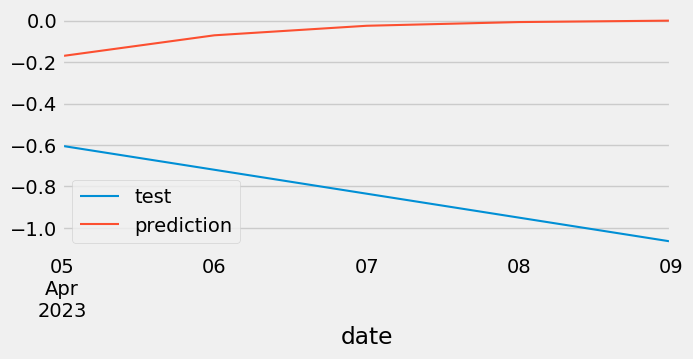

In [73]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [74]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.6575215306306037


In [75]:
data_test['y'] = scaler.inverse_transform(data_test['y'].values.reshape(len(data_test['y']),1))
data_test['y']

date
2023-04-05    16273000.0
2023-04-06    12582250.0
2023-04-07     8891500.0
2023-04-08     5200750.0
2023-04-09     1510000.0
Freq: D, Name: y, dtype: float64

In [76]:
predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
predictions['prediction']

date
2023-04-05    3.012317e+07
2023-04-06    3.332527e+07
2023-04-07    3.479640e+07
2023-04-08    3.536769e+07
2023-04-09    3.558954e+07
Freq: D, Name: prediction, dtype: float64

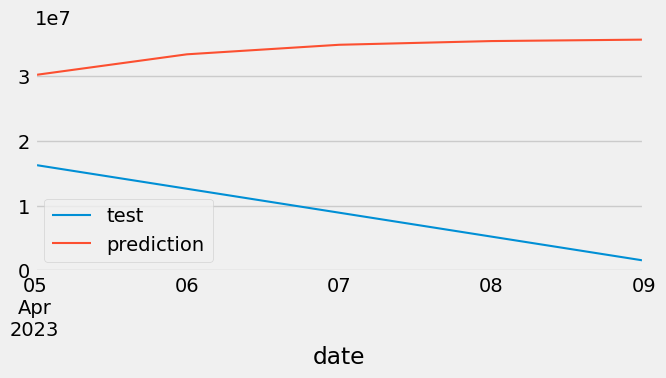

In [77]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [78]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 672924559792821.2


# Hasil

In [79]:
#HASIL
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
date,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [ ]:
import joblib

distinct_route = df[['kode_org', 'kode_des']].drop_duplicates()
pred_results = []
order = 0
for row in distinct_route.values:
    
    order += 1
    print("dataset ke-",order)
    
    #mengambil data set berdasarkan kode org |row[0]| - kode des |row[1]| (Rute)
    data = df.loc[(df['kode_org']==row[0]) & (df['kode_des']==row[1])]
    data = data.groupby(['date'])['y'].sum()
    data = pd.DataFrame(data)
    
    print(f"start date: {min(data.index)}, end date: {max(data.index)}")
    
    #ELIMINATING OUTLIERS WITH IQR
    print("panjang dataset dengan outliers :",len(data))
    n = 0
    x = 1
    while x != 0:   
        n+=1
        q1 = data['y'].quantile(0.25)
        q3 = data['y'].quantile(0.75)
        iqr = q3 - q1
        # identify outliers
        lower_fence = q1 - 1.5*iqr
        upper_fence = q3 + 1.5*iqr
        outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
        x= len(outliers)
        #print("Outliers ke-",n,": ",outliers)
        data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
    print("panjang dataset tanpa outliers :",len(data))
    
    #FILLING DATA GAPS WITH INTERPOLATION
    data = data.asfreq('d')
    data = data.interpolate(method='linear')
    print("Jumlah data setelah interpolasi :",len(data))
    data = data.astype({'y':'int'})
    
    #DATA NORMALIZATION
    unscaled = data['y'].values.reshape(len(data['y']),1)
    scaler = StandardScaler()
    scaler.fit(unscaled)
    scaled = scaler.transform(unscaled)
    data['y'] = scaled
    data['y']    
    
    #SPLIT DATA BUAT DAPETIN STEP YANG DIBUTUHIN BUAT PREDICT CURRENT TIME
    sum_data = len(data)
    today = datetime.date.today()
    today_with_timestamp = datetime.datetime.combine(today, datetime.time.min)
    max_date = data.index.max()
    new_row = pd.DataFrame({'date': today_with_timestamp, 'y': [None], 'org': [None], 'kode_org': [None], 'des': [None], 'kode_des': [None]})
    new_row = new_row.set_index('date')
    data = pd.concat([data, new_row], axis=0)
    data = data.asfreq('d')
    sum_timeline = len(data)
    steps = sum_timeline-sum_data
    data_train = data[:-steps]
    
    #VALIDASI APAKAH DATA BISA DI SPLIT UNTUK GRID SEARCH ATAUT TIDAK
     #based on data priuk-batam kalau ga bisa grid search 
#     if len(data)>steps:
#         data_train_HPO = data_train[:-steps]
#         data_test_HPO  = data_train[-steps:]
#         print(f"Train dates : {data_train_HPO.index.min()} --- {data_train_HPO.index.max()}  (n={len(data_train_HPO)})")
#         print(f"Test dates  : {data_test_HPO.index.min()} --- {data_test_HPO.index.max()}  (n={len(data_test_HPO)})")
        
#         #GRID SEARCH untuk HPO
#         p_values = range(0, 2)
#         d_values = range(0, 3)
#         q_values = range(0, 3)
        
#         warnings.filterwarnings("ignore")
        
#         best_rmse, best_order = float('inf'), None
#         for p, d, q in itertools.product(p_values, d_values, q_values):
#                 # Fit the ARIMA model to the training data
#                 model = ARIMA(data_train_HPO['y'].values,order=(p,q,d))
#                 model_fit = model.fit()
#                 # Make predictions on the test data
#                 predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
#                 predictions.index = data_test_HPO.index
#                 # Calculate the RMSE of the predictions
#                 rmse = mean_squared_error(
#                         y_true = data_test_HPO['y'],
#                         y_pred = predictions['prediction']
#                     )
#                 print("{p:",p,"d:",d,"q:",q,"rmse:",rmse,"}")
#                 # Check if this is the best model so far
#                 if rmse < best_rmse:
#                     best_rmse = rmse
#                     best_order = (p, d, q)
#         print(f"Best Score : {best_rmse} --- (Best Order={best_order})")
    try:
        best_order = (1,0,2)
        #fit forecaster
        arima_model = ARIMA(data_train['y'].values,order=(best_order))
        arima_results = arima_model.fit()

        #predict result
        y_pred = arima_results.forecast(steps=steps)
        predictions = pd.DataFrame(y_pred,columns=['prediction'])
        predictions.index = data_test.index
        predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
        this_result = [today_with_timestamp,row[0],row[1],predictions['prediction']]
        pred_results.append(this_result)
        print("{res:",this_result,"}")
        # define the file name you want to save the model as
        filename = (f"C://Users//LENOVO//Downloads//Revenue_OD_ARIMA/{row[0]}_{row[1]}.sav")

        # use joblib.dump() to save the model to disk
        joblib.dump(arima_model, filename)
    except: #klo prediksi gagal karena kekurangan jumlah data , yang di pake adalah satu-satunya data yang ada di OD tersebut
        print("Can't Create Model, Not Enough Data")
        data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
        this_result = [today_with_timestamp,row[0],row[1],data['y'].values[0]]
        pred_results.append(this_result)
        print("{res:",this_result,"}")
